In [17]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm, solve, LinAlgError
from dataclasses import dataclass

def forward_xy(theta, L1, L2):
    t1, t2 = map(float, theta)
    x = L1*np.cos(t1) + L2*np.cos(t1 + t2)
    y = L1*np.sin(t1) + L2*np.sin(t1 + t2)
    return np.array([x, y], dtype=float)

def residual(theta, L1, L2, xd, yd):
    return forward_xy(theta, L1, L2) - np.array([xd, yd], dtype=float)

def jacobian(theta, L1, L2):
    t1, t2 = map(float, theta)
    s1, c1 = np.sin(t1), np.cos(t1)
    s12, c12 = np.sin(t1 + t2), np.cos(t1 + t2)
    return np.array([[-L1*s1 - L2*s12, -L2*s12],
                     [ L1*c1 + L2*c12,  L2*c12]], dtype=float)

def reachable(xd, yd, L1, L2):
    r = np.hypot(xd, yd)
    return abs(L1 - L2) <= r <= (L1 + L2)

def normalize_angles(theta):
    """Normalize each angle to (-pi, pi]."""
    th = np.array(theta, dtype=float)
    return (th + np.pi) % (2*np.pi) - np.pi

@dataclass
class NewtonResult:
    theta: np.ndarray
    f_norm: float
    iters: int
    converged: bool
    history: list

def newton_ik(L1, L2, xd, yd, theta0,
              tol_f=1e-10, tol_x=1e-12, kmax=50,
              clamp_angles=True, verbose=False):
    th = np.array(theta0, dtype=float)
    hist = []

    for k in range(kmax):
        F = residual(th, L1, L2, xd, yd)
        f_inf = norm(F, ord=np.inf)

        # Newton step
        J = jacobian(th, L1, L2)
        try:
            s = solve(J, -F)
        except LinAlgError:
            s = solve(J + 1e-10*np.eye(2), -F)

        th_new = th + s
        if clamp_angles:
            th_new = normalize_angles(th_new)

        hist.append({"k": k, "theta": th.copy(), "f_inf": f_inf,
                     "step_norm": norm(s)})

        if f_inf <= tol_f:
            return NewtonResult(th, f_inf, k, True, hist)
        if norm(th_new - th, ord=np.inf) <= tol_x:
            th = th_new
            F = residual(th, L1, L2, xd, yd)
            return NewtonResult(th, norm(F, ord=np.inf), k+1, True, hist)

        th = th_new

    F = residual(th, L1, L2, xd, yd)
    return NewtonResult(th, norm(F, ord=np.inf), kmax, False, hist)

def run_grid_analysis(L1, L2, xd, yd, n=50, kmax=40, tol_f=1e-8):
    theta1_grid = np.linspace(-np.pi, np.pi, n)
    theta2_grid = np.linspace(-np.pi, np.pi, n)

    labels = np.zeros((n, n), dtype=int)
    iters_map = np.full((n, n), np.nan)

    for i, t1 in enumerate(theta1_grid):
        for j, t2 in enumerate(theta2_grid):
            res = newton_ik(L1, L2, xd, yd, theta0=np.array([t1, t2]),
                            kmax=kmax, tol_f=tol_f)
            if res.converged and res.f_norm <= tol_f:
                labels[j, i] = 1 if res.theta[1] < 0 else 2
                iters_map[j, i] = res.iters
            else:
                labels[j, i] = 0

    return labels, iters_map, theta1_grid, theta2_grid

def plot_basins(labels, th1, th2, title):
    plt.figure()
    plt.imshow(labels, origin='lower',
               extent=[th1[0], th1[-1], th2[0], th2[-1]],
               aspect='auto')
    plt.xlabel(r'$\\theta_1$ (rad)')
    plt.ylabel(r'$\\theta_2$ (rad)')
    plt.title(title)
    plt.colorbar(label='0=no conv, 1=down, 2=up')
    plt.show()

def plot_iters_map(iters_map, th1, th2, title):
    plt.figure()
    plt.imshow(iters_map, origin='lower',
               extent=[th1[0], th1[-1], th2[0], th2[-1]],
               aspect='auto')
    plt.xlabel(r'$\\theta_1$ (rad)')
    plt.ylabel(r'$\\theta_2$ (rad)')
    plt.title(title + " (NaN = no conv)")
    plt.colorbar(label='# iters')
    plt.show()
    

def forward_points(theta, L1, L2):
    """Devuelve las coordenadas [(0,0), (x1,y1), (x2,y2)]."""
    t1, t2 = map(float, theta)
    x1 = L1*np.cos(t1); y1 = L1*np.sin(t1)
    x2 = x1 + L2*np.cos(t1+t2); y2 = y1 + L2*np.sin(t1+t2)
    return [(0,0), (x1,y1), (x2,y2)]

**Planar robotic arm**

Given two links of length ***L1*** and ***L2***, both articulated and arranged at a certain angle ϴ, we want to find the final visualization of both links and the path traveled.


**Visualization by iterations**

In this format, we will identify each Newton process by iteration.



In [18]:
def plot_iterations_step_by_step(history, L1, L2, xd, yd, angles_in_degrees=True):
    """Draws the arm at each iteration and shows the angles."""
    for k, h in enumerate(history):
        plt.figure(figsize=(6,6))

        # arm coordinates
        pts = forward_points(h["theta"], L1, L2)
        xs, ys = zip(*pts)
        plt.plot(xs, ys, '-o', color="blue", label=f"Iter {k}")

        # destination
        plt.plot([xd], [yd], 'gx', markersize=10, label="Destination")

        # aesthetics
        reach = L1 + L2
        plt.xlim(-reach-0.1, reach+0.1)
        plt.ylim(-reach-0.1, reach+0.1)
        plt.gca().set_aspect("equal")
        plt.grid(True)
        plt.legend()

        # show angles
        t1, t2 = h["theta"]
        if angles_in_degrees:
            t1, t2 = np.degrees(t1), np.degrees(t2)
            plt.title(f"Iter {k} | θ1={t1:.2f}°, θ2={t2:.2f}° | ||F||={h['f_inf']:.2e}")
        else:
            plt.title(f"Iter {k} | θ1={t1:.4f} rad, θ2={t2:.4f} rad | ||F||={h['f_inf']:.2e}")

        plt.show()
        
        

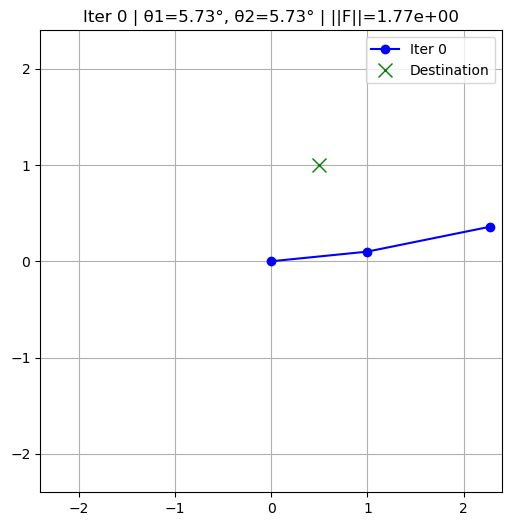

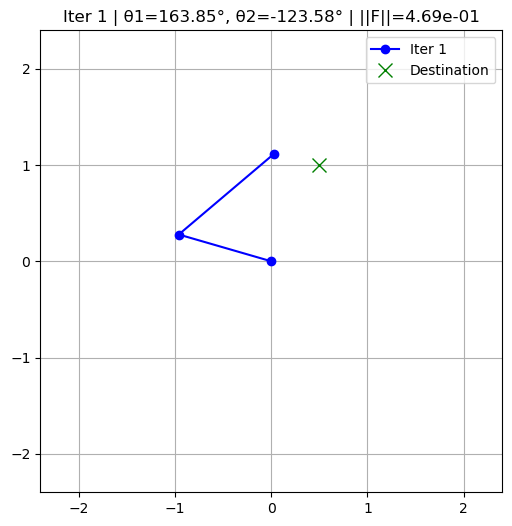

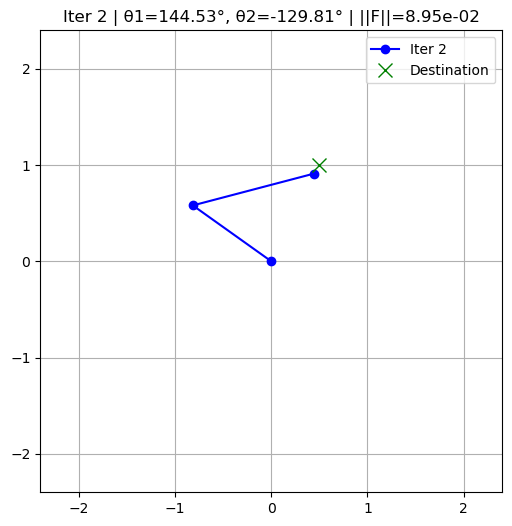

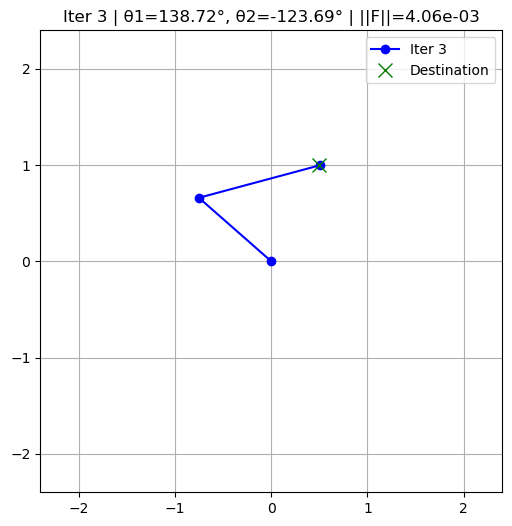

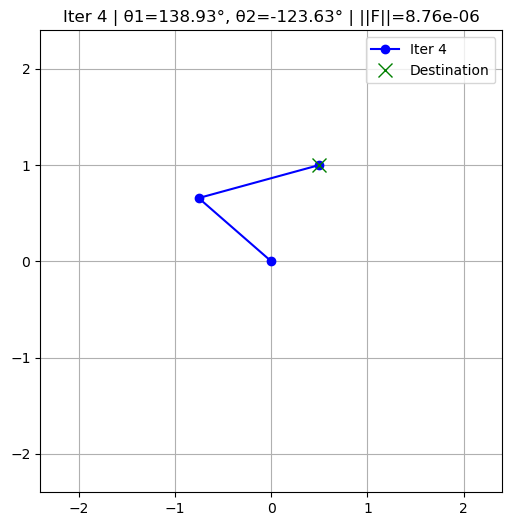

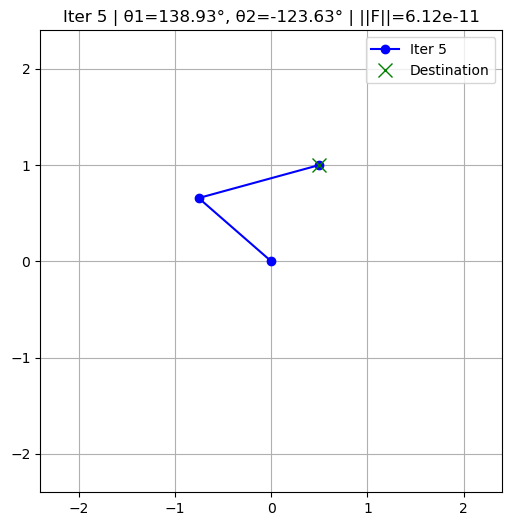

In [19]:
L1, L2 = 1.0, 1.3
xd, yd = 0.5, 1.0
theta0 = [0.1, 0.1]

res = newton_ik(L1, L2, xd, yd, theta0)
plot_iterations_step_by_step(res.history, L1, L2, xd, yd, angles_in_degrees=True)

**Now a complete visualization of the arm's path**

We start from iteration 0, where both arms are extended but with an angular deviation from the x-axis. We also find the trace of each iteration and the arm in its final position.


In [20]:
def plot_full_trajectory(history, L1, L2, xd, yd):
    """Draws all arm iterations in the same plane."""
    plt.figure(figsize=(7,7))
    end_points = []

    for k, h in enumerate(history):
        pts = forward_points(h["theta"], L1, L2)
        xs, ys = zip(*pts)

        # draw arm for this iteration
        plt.plot(xs, ys, '-o', alpha=0.3)

        # save end effector position
        end_points.append(pts[-1])

    # draw end effector trajectory
    ex, ey = zip(*end_points)
    plt.plot(ex, ey, '--k', linewidth=1.5, label="Newton points trajectory")

    # initial arm in blue
    xs, ys = zip(*forward_points(history[0]["theta"], L1, L2))
    plt.plot(xs, ys, '-o', alpha=0.5, color="blue", linewidth=1, label="Initial")

    # final arm in red
    xs, ys = zip(*forward_points(history[-1]["theta"], L1, L2))
    plt.plot(xs, ys, '-o', color="red", linewidth=2, label="Final")

    # destination
    plt.plot([xd], [yd], 'gx',linewidth=2, markersize=15, label="Destination")

    reach = L1 + L2
    plt.xlim(-reach-0.2, reach+0.2)
    plt.ylim(-reach-0.2, reach+0.2)
    plt.gca().set_aspect("equal")
    plt.grid(True)
    plt.legend()
    plt.title("Arm trajectory in the plane")
    plt.show()

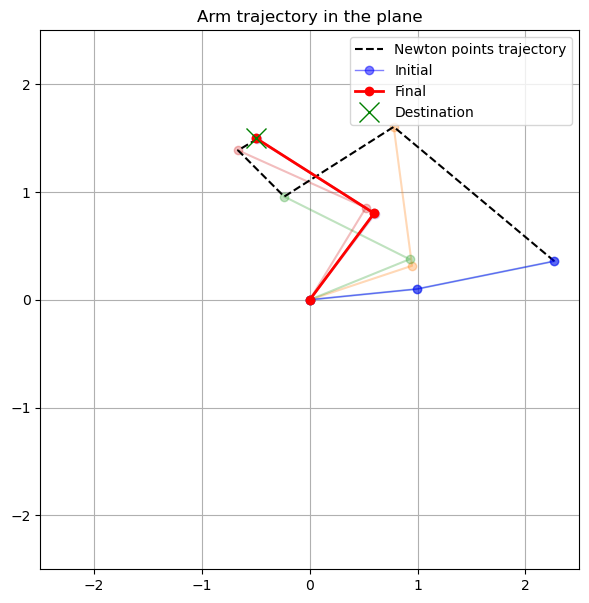

In [25]:
L1, L2 = 1.0, 1.3
xd, yd = -0.5, 1.5
theta0 = [0.1, 0.1]

res = newton_ik(L1, L2, xd, yd, theta0)
plot_full_trajectory(res.history, L1, L2, xd, yd)